# GNN demo

## Imports

In [1]:
from typing import Union, List, Tuple

import pandas as pd
import pickle as pkl
import numpy as np
from torch_geometric.data import InMemoryDataset, Data
import torch

path2root = '.'

## Load data

In [2]:
G_data = pkl.load(open(f'{path2root}/data/G_data.pkl', 'rb'))
G_data.keys()

dict_keys(['edge_index', 'num_nodes', 'embeddings', 'recipes_similarities', 'comb_recipe_similarities', 'serial_to_index', 'index_to_serial'])

In [3]:
edge_index, num_nodes, embeddings, y = G_data['edge_index'], G_data['num_nodes'], G_data['embeddings'], G_data[
    'recipes_similarities'].sort_index().sort_index(axis=1).values
edge_index = torch.from_numpy(edge_index)

In [4]:
# custom dataset
class MyDataset(InMemoryDataset):
    def __init__(self, edge_index, num_nodes, embeddings, y, G_data, transform=None):
        super(MyDataset, self).__init__('.', transform, None, None)
        data = Data(edge_index=edge_index)
        data.num_nodes = num_nodes
        # embedding
        data.x = torch.from_numpy(embeddings).type(torch.float32)
        data.G_data = G_data
        # y - similarities
        data.y = y
        data.recipes_indexes = [v for k, v in data.G_data['serial_to_index'].items() if type(k) == str]
        self.data, self.slices = self.collate([data])

In [5]:
dataset = MyDataset(edge_index=edge_index, num_nodes=num_nodes, embeddings=embeddings, y=y, G_data=G_data)
data = dataset[0]

In [6]:
data.x

tensor([[0.2857, 0.2857, 0.0000,  ..., 0.5600, 0.1071, 0.9116],
        [0.0000, 0.1429, 0.0000,  ..., 0.7273, 0.0357, 0.6193],
        [0.7500, 0.0000, 0.0000,  ..., 0.8235, 0.1518, 0.6136],
        ...,
        [0.2500, 0.2500, 0.2500,  ..., 1.0000, 1.0000, 0.8000],
        [0.2500, 0.2500, 0.2500,  ..., 1.0000, 1.0000, 0.9000],
        [0.2500, 0.2500, 0.2500,  ..., 1.0000, 1.0000, 1.0000]])

## Model

In [7]:
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv

In [8]:
class Net(torch.nn.Module):
    def __init__(self, out_features):
        super(Net, self).__init__()
        self.conv1 = GCNConv(data.num_features, 16)
        self.conv2 = GCNConv(16, out_features)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = self.conv2(x, edge_index)
        return x

In [9]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
data = data.to(device)
model = Net(out_features=10).to(device)
x = model(data)

## Training

In [12]:
from tqdm import tqdm
import random
import matplotlib.pyplot as plt
from random import choices

100%|██████████| 499/499 [00:26<00:00, 18.58it/s]


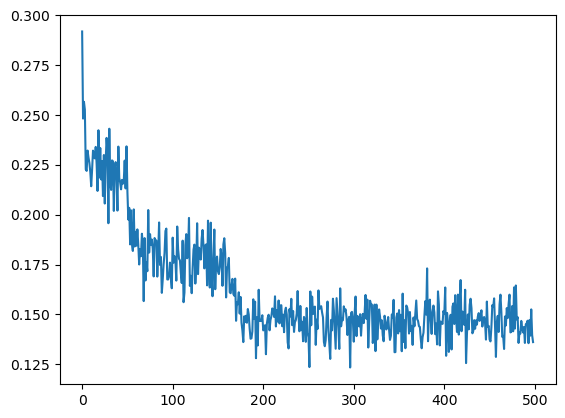

In [39]:
torch.manual_seed(42)

optimizer_name = "Adam"
lr = 1e-1
optimizer = getattr(torch.optim, optimizer_name)(model.parameters(), lr=lr)
epochs = 500


def similarity_loss(outputs, data, batch_size=500):
    pairs = list(zip(choices(data.recipes_indexes, k=batch_size), choices(data.recipes_indexes, k=batch_size)))
    pairs = np.array(pairs)
    pairs = pairs[pairs[:, 0] != pairs[:, 1]]
    edges_similarities = torch.from_numpy(data.y[pairs[:, 0], pairs[:, 1]]).to(dtype=torch.float32)
    cosines = nn.CosineSimilarity()(outputs[pairs[:, 0]], outputs[pairs[:, 1]])
    MSE = nn.MSELoss()(cosines, edges_similarities)
    return MSE


def train(data):
    model.train()
    optimizer.zero_grad()
    outputs = model(data)
    loss = similarity_loss(outputs, data)
    loss.backward()
    optimizer.step()
    return loss


losses = []
for epoch in tqdm(range(1, epochs)):
    loss = train(data)
    losses.append(loss.item())

plt.plot(list(range(len(losses))), losses)
plt.show()

In [43]:
outputs = model(data).detach().numpy()

In [47]:
final_features = pd.DataFrame(outputs)
final_features.index = final_features.index.map(G_data['index_to_serial'].get)
final_features

,0,1,2,3,4,5,6,7,8,9
7abae8bd52,-30.647837,10.047721,-35.176067,36.963055,-85.572395,11.003420,-36.375359,80.876350,119.171715,121.124580
8a705a7781,-105.340103,-27.229498,2.532598,-72.657341,36.420887,23.104284,-7.765224,70.509941,75.093300,90.214745
bcde847269,359.504181,7.902899,371.984344,-167.597870,91.694199,-1112.838867,-820.837524,47.520573,1232.045776,11.618207
e848172f78,45.870625,13.946721,4.518616,-14.460531,-19.475647,133.431778,-101.606880,15.329460,31.267460,-68.327339
868482568e,-21.483486,-27.551577,5.946500,-50.398266,9.543095,-2.249704,-34.241539,47.425995,63.871365,8.591961
...,...,...,...,...,...,...,...,...,...,...
"(1, 1, 1, 1, 2, 10, 6)",-85.054802,-4.949015,-98.582504,-130.412506,219.387329,-93.882736,135.144653,81.329758,72.617157,61.884583
"(1, 1, 1, 1, 2, 10, 7)",-90.484184,-4.748360,-91.970695,-123.949005,202.100723,-87.349648,122.709694,84.491562,82.081612,73.629044
"(1, 1, 1, 1, 2, 10, 8)",-95.913582,-4.547703,-85.358871,-117.485497,184.814117,-80.816544,110.274757,87.653351,91.546074,85.373543
"(1, 1, 1, 1, 2, 10, 9)",-101.342995,-4.347037,-78.747063,-111.022003,167.527542,-74.283455,97.839821,90.815163,101.010536,97.118019


In [48]:
pkl.dump(final_features, open(f'{path2root}/data/final_features.pkl', 'wb'))